# Evaluating FRANKEN-Z on Mock Data

This notebook demonstrates some of the motivations and core functionalities of **FRANKEN-Z**: **F**ull **R**egression over **A**ssociated **N**eighbors with **K**ernel d**E**nsity estimatio**N** for Redshifts (**Z**) by comparing its performance to template fitting-oriented approaches.

We first outline and demonstrate standard **likelihood-fitting** approaches along with the addition of simple Bayesian priors. Once this is done, we then transition to the more realistic (and **machine-learning** inspired) case where we only have access to a noisy training set of photometry. We then examine how traiditional **scale-free** likelihood fitting (i.e. fitting in color space) compare with the more direct **scale-dependent** version (i.e. fitting in magnitude space).

Once this is done, we compare how well FRANKEN-Z performs on the sample. After confirming we do a good job recovering the underlying $dN/dz$ distribution, we then show how easy it is to incorporate the impact of **testing-sample selection effects** into FRANKEN-Z's redshift predictions.

Finally, we show how FRANKEN-Z facilitates hierarchical Bayesian modeling, which enables us to sample from the joint population-individual object distribution, as well as incorporating additional **training-sample selection effects**.

Note that this code requires **BPZ** [v1.99](http://www.stsci.edu/~dcoe/BPZ/), which contains the type-magnitude-redshift priors used here.

## Setup

In [1]:
import sys # system commands
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d # interpolation
from scipy import stats # statistics functions
from scipy import special # special functions

# BPZ
bpz_dir = '/Users/Josh/Dropbox/bpz-1.99.3/' # BPZ directory
sys.path.append(bpz_dir)
from prior_hdfn_gen import function as bpz_prior

# FRANKEN-Z
import frankenz as fz

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


We first import our mock data and templates from the previous notebook (*mock_survey.ipynb*).

In [2]:
# load observed data
data=load('mock_catalog_hsc-cosmos.npy')
phot_d=data[:,[0,1,2,3,4]] # fluxes
err_d=data[:,[5,6,7,8,9]] # flux errors
var_d=square(err_d) # flux variances
mask_d=(err_d>0.) # mask for missing data
redshift_d=data[:,10] # redshifts
types_d=data[:,11].astype(int) # types
Nobs=len(data) # number of objects

Nclass=(8,11,12) # passive, spiral, and starburst galaxies, respectively
maglims=[26.5,26.1,25.9,25.1,24.4] # g,r,i,z,y 5-sigma limits for HSC data

Nf=len(phot_d[0]) # number of filters
flux_zeropoint=10**(-0.4*-23.9) # AB magnitude zeropoint
skynoise=median(err_d,axis=0)
mag_d,magerr_d=fz.asinh_mag_map(phot_d,err_d,skynoise,zeropoint=flux_zeropoint) # Luptitude mapping

# load model data
models=load('model_catalog_hsc-cosmos.npy')
phot_m=models[:,[0,1,2,3,4]] # fluxes
err_m=zeros(phot_m.shape) # flux errors
var_m=square(err_m) # flux variances
mask_m=ones(phot_m.shape).astype(bool) # mask for missing data
redshift_m=models[:,-2] # redshifts
types_m=models[:,-1].astype(int) # types
Nmodels=len(models) # number of objects

# template grid
Ut,t_inv=unique(types_m,return_inverse=True) # order unique types
Nt=len(Ut) # number of unique types

# redshift grid
Uz,z_inv=unique(redshift_m,return_inverse=True) # ordered unique redshifts
Nz=len(Uz) # number of unique redshifts
dz=Uz[1]-Uz[0]

# discretize redshifts
zidx_m=((redshift_m-Uz[0])/(Uz[1]-Uz[0])).round().astype(int)

Now let's set up FRANKEN-Z. The master configuration file simply tells the code:

- where to position the home directory,
- where to look for filters,
- what filter set to use, and
- what dictionaries it should be using.

In [3]:
# master config file
config=fz.ReadParams('config/frankenz.config') 

# import filters
filt=fz.ReadFilters(config.params['FILTERS'],path=config.params['FILTER_PATH'])

One of the ways FRANKEN-Z differes from other photometric redshift (photo-z) codes is that it tries to avoid discretizing quantities wherever possible. Since redshifts, fluxes, and many other photometric quantities are **fundamentally continuous parameters with smooth, continuous PDFs**, we attempt to work directly in this continuous space whenever possible instead of resorting to binning.

To accomplish this, we utilize **kernel density estimation (KDE)**. Almost all photometric observable PDFs are modeled as Gaussians (i.e. Normals), so by connecting each observable with an associated Gaussian kernel density (determined by  measurement errors) we can *in theory* construct a density estimate at any location in parameter space by evaluating the probability density of each and every kernel at that location.

In practice, this type of brute-force KDE is prohibitively expensive. As a result, we can attempt to compute very good approximations to the true kernel density for any particular object by (1) evaluating only a small subset of "nearby" kernels to approximate the true density or (2) evaluating the overall kernel density estimates over a set of discrete basis functions (see Speagle et al. in prep. for details). FRANKEN-Z takes advantage of **both** of these ideas when computing photo-z's. 

In addition, FRANKEN-Z also speeds up computation by discretizing our original set of Gaussian kernels using a stationary **pre-computed Gaussian dictionary** that can slide around on a discretized parameter grid. This helps avoid repetitive, expensive computations at the (very small) cost of increasing overhead. The parameters for these are stored in additional config files referenced within our master configuration file.

In [4]:
# initialize supplementary dictionaries
mdict=fz.PDFDict(config.CONFIG_MAG.params) # magnitude
cdict=fz.PDFDict(config.CONFIG_COLOR.params) # color
midx_d,meidx_d=mdict.fit(mag_d,magerr_d) # discretized magnitudes

It is important to note that our assumption about translational-invariant kernels **does not** hold in redshift space, which is multiplicative (and generally has scale-dependent errors). However, it **does** hold in $\ln(1+z)$ space (which we would argue is a more natural place to do fitting anyway). As a result, FRANKEN-Z fundamentally computes redshift PDFs in $\ln(1+z)$ space, but can convert quantities back to the more typically used redshift-space PDFs.

In [5]:
# initialize redshift dictionary
rdict=fz.RedshiftDict(config.CONFIG_REDSHIFT.params)

# add names so easier to reference later
rdict.sig_dict=rdict.lze_dict
rdict.sig_width=rdict.lze_width
rdict.delta=rdict.dlz_highres
rdict.grid=rdict.lzgrid_highres
rdict.Ngrid=rdict.Nz_highres

# discretize redshifts
lzidx_d,lzeidx_d=rdict.fit(log(1+redshift_d),ones(Nobs)*rdict.dlz) # data
lzidx_m,lzeidx_m=rdict.fit(log(1+redshift_m),ones(Nmodels)*rdict.dlz) # models

## Selection Effects

Our underlying catalog extends to below the magnitude ranges we can hope to probe due to noise detection limits and selection functions. Let's apply a basic selection function here as simply a cut in $i$-band magnitude, mirroring  [Leistedt et al. (2016)](http://adsabs.harvard.edu/abs/2016MNRAS.460.4258L).

In [6]:
sel=(mag_d[:,2]<maglims[2]) # applying i-band cut
Nsel = sel.sum() # number of galaxies post-cut
print 'Number of observed galaxies (all):',Nobs
print 'Number of observed galaxies (selected):',Nsel
print 'Number of models:',Nmodels

Number of observed galaxies (all): 500000
Number of observed galaxies (selected): 181162
Number of models: 18631


Let's visualize the impact this cut has on our sample. We'll take advantage of FRANKEN-Z's KDE functions to incorporate measurement errors into the PDF.

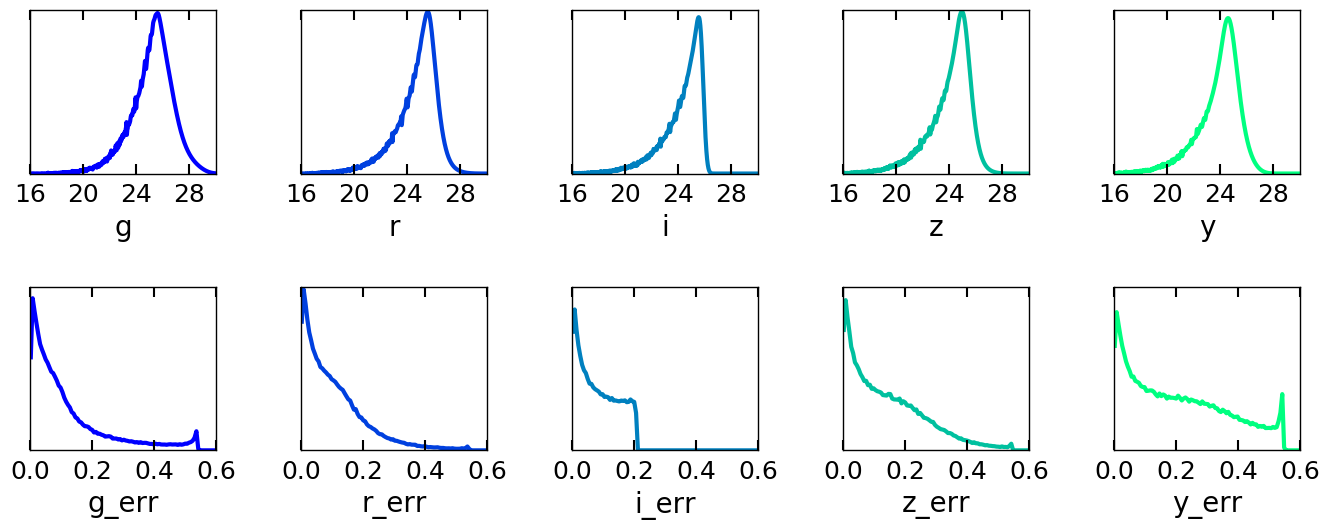

In [7]:
# plotting magnitude distribution
fcolors=get_cmap('winter')(linspace(0,1,Nf)) # filter colors
figure(figsize=(14,6))
for i in xrange(Nf):
    subplot(2,Nf,i+1)
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,midx_d[:,i],meidx_d[:,i],sel.astype(int),
                            mdict.grid,mdict.delta,mdict.Ngrid) # smooth PDF generated using input dictionaries
    plot(mdict.grid,mag_pdf,lw=3,color=fcolors[i])
    xlim([16,30])
    yticks([])
    xticks(arange(16,30,4),fontsize=18)
    xlabel(filt.filters[i],fontsize=20)
    tight_layout()
    subplot(2,Nf,i+1+Nf)
    h,bins=histogram(magerr_d[:,i][sel],normed=True,range=[0,0.6],bins=100)
    plot((bins[:-1]+bins[1:])/2.,h,lw=3,color=fcolors[i])
    xticks(linspace(0,0.6,4),fontsize=18)
    xlabel(filt.filters[i]+'_err',fontsize=20)
    yticks([])
    tight_layout()

Note that the error "spike" seen at $\sim 0.5$ is a result of our usage of asinh magnitudes (i.e. "Luptitudes"; [Lupton et al. 1999](http://adsabs.harvard.edu/abs/1999AJ....118.1406L)) rather than log10 magnitudes in order to incorporate data with negative measured fluxes, and traces the sky background.

Let us now compute the redshift KDE.

**Important note**: When calculating our PDFs in $\ln(1+z)$ space, we actually compute them at a higher-resolution before downsampling them to the desired resolution to maintain precision. We also include left-/right-padding to avoid edge effects. Also, when recasting our PDFs from $\ln(1+z)$ to redshift space, we need to correct for the change from logarithmic to linear density. These are all done below.

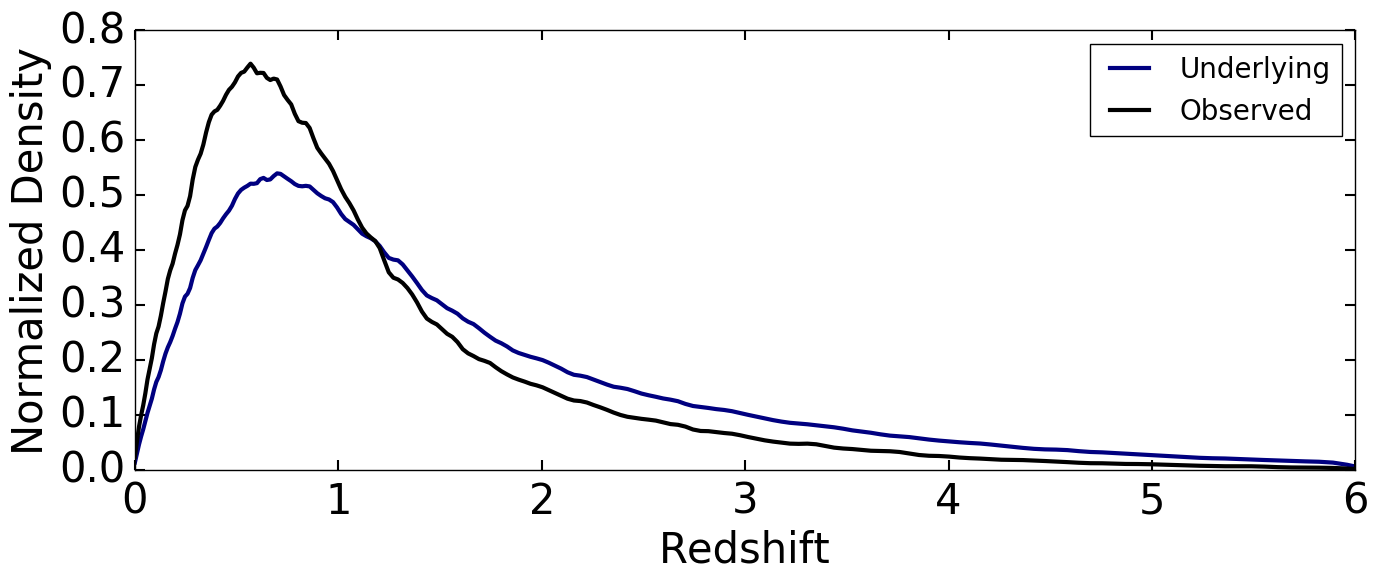

In [8]:
# plotting redshift distribution
figure(figsize=(14,6))

# all
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_d,lzeidx_d,ones(Nobs),
                      rdict.grid,rdict.delta,rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)] # truncating edges
z_pdf/=rdict.znorm # converting from log(1+z) to z density
z_pdf/=trapz(z_pdf,rdict.zgrid) # normalizing
plot(rdict.zgrid,z_pdf,lw=3,color='navy',label='Underlying')

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_d,lzeidx_d,sel.astype(int),
                      rdict.grid,rdict.delta,rdict.Ngrid) # smooth PDF generated using input dictionaries
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm # truncation, downsample, normalize
z_pdf/=trapz(z_pdf,rdict.zgrid)
plot(rdict.zgrid,z_pdf,lw=3,color='black',label='Observed')

xlim([Uz.min(),Uz.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

As expected (and shown in *mock_survey.ipynb*), our selection effect has a huge impact on our observed redshift distribution.

## Likelihood fitting with models

First we investigate the **ideal case** where we know the underlying models (**and priors**) used to generate the data. This is similar to the assumptions typically made in likelihood-fitting (i.e. template-based) photo-z codes. Using a basic grid in template/redshift, we use brute-force methods to compute photo-z PDFs using **scale-free likelihoods** (i.e. fitting in color) both with and without incorporating BPZ priors.

In other words, our likelihood can be written as

\begin{equation}
-2\ln\mathcal{L}(s) \propto \chi^2(s)=\sum_i \frac{\left(F_{\textrm{obs},i} - sF_{\textrm{model},i} \right)^2}{\sigma_{\textrm{obs},i}^2},
\end{equation}

where we have assumed independent errors (i.e. the covariance matrix is diagonal) and $s$ is the **maximum-likelihood** (ML) scalefactor

\begin{equation}
s=\frac{\sum_i F_{\textrm{obs},i} F_{\textrm{model},i}}{\sum_i F_{\textrm{model},i} F_{\textrm{model},i}}
\end{equation}

and the sum over $i$ is taken over all available bands. This is implemented via the *loglikelihood_s* function.

**Important note**: ignoring errors on $\mathbf{F}_{\textrm{model}}$, our scale-dependent likelihood as written above is both the marginalized likelihood *and* ML estimator (MLE) over $s$. However, **this is no longer true if we do not ignore errors on $\mathbf{F}_{\textrm{model}}$**. In that case, no closed-form solution exists (this can be understood through the properties of the [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution)). The MLE can be computed by numerically minimizing 

\begin{equation}
\chi^2(s)=\sum_i \frac{\left(F_{\textrm{obs},i} - sF_{\textrm{model},i} \right)^2}{\sigma_{\textrm{obs},i}^2+s^2\sigma_{\textrm{model},i}^2}
\end{equation}

over $s$, while the marginalized likelihood requires numerically integrating the above expression over $\mathbf{F}_{\textrm{model}}$.

Unfortunately, since brute-force likelihood computations are slow, we have to downsample the data to ensure our tests don't take forever.

In [9]:
downsample=20
Nsub=Nsel/downsample+1

Now we're ready to compute our likelihoods.

In [10]:
# Redshift PDFs and -2ln(evidence) (raw)
zpdf_raw=empty((Nsub,Nz))
levidence_raw=empty(Nsub)

# Redshift PDFs and -2ln(evidence) (BPZ)
zpdf_bpz=empty((Nsub,Nz))
levidence_bpz=empty(Nsub)

sel_arr=arange(Nobs)[sel][::downsample]
for count in arange(Nsub):
    if count%100==0: sys.stdout.write(str(count)+' ')
    i=sel_arr[count] # counter
    ll,Nbands=fz.loglikelihood_s(phot_d[i],var_d[i],mask_d[i],phot_m,var_m,mask_m) # log-likelihoods and Nbands used in fit 
    llmin=ll.min() # minimum value (for scaling)
    
    # Raw likelihoods
    weights=exp(-0.5*(ll-llmin)) # scaled likelihood weights
    levidence_raw[count]=-2*log(weights.sum())+llmin # -2ln(Evidence)
    zpdf_raw[count]=[weights[z_inv==j].sum() for j in xrange(Nz)] # P(z) (raw)

    # BPZ posteriors
    weights_bpz=weights*bpz_prior(Uz,mag_d[i][2],(8,11,12))[zidx_m,types_m] # posterior weights    
    levidence_bpz[count]=-2*log(weights_bpz.sum())+llmin # -2ln(Evidence) (BPZ)
    zpdf_bpz[count]=[weights_bpz[z_inv==j].sum() for j in xrange(Nz)] # P(z) (BPZ)

# normalize PDFs    
zpdf_raw/=zpdf_raw.sum(axis=1)[:,None]
zpdf_bpz/=zpdf_bpz.sum(axis=1)[:,None]

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 

Note that we have chosen to normalize our PDFs to *sum* (rather than integrate) to one to facilitate subsequent operations (e.g., computing means). This is also the normalization used in FRANKEN-Z.

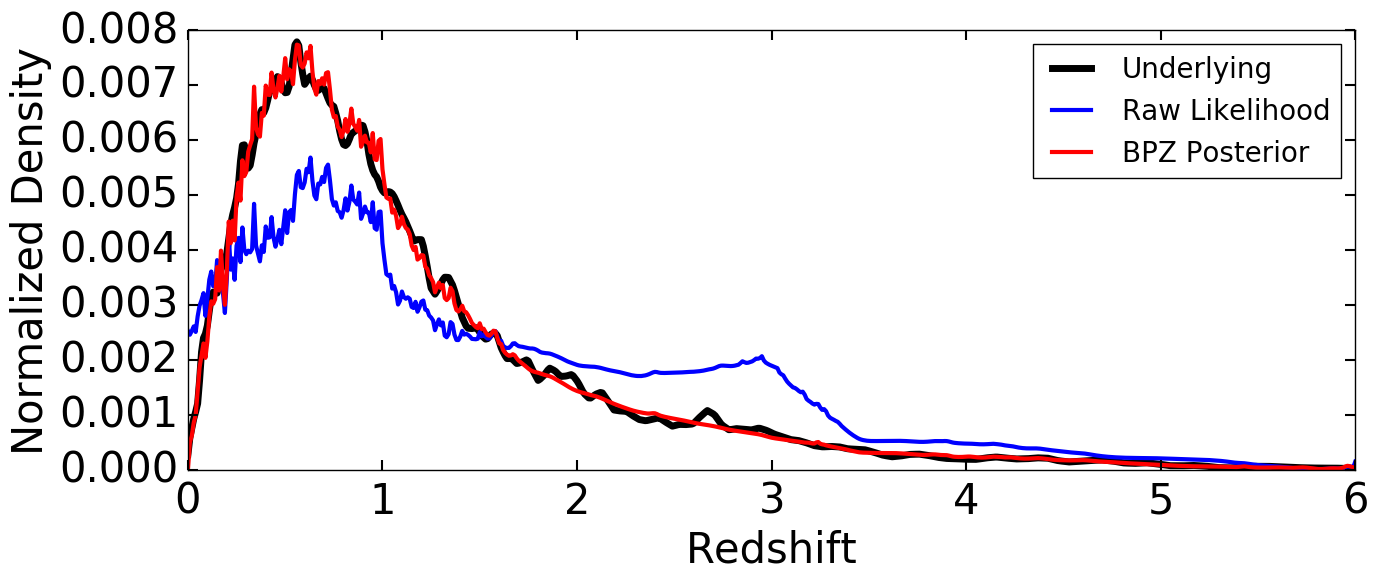

In [11]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_d[sel][::downsample],lzeidx_d[sel][::downsample],
                      ones(Nsub),rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(Uz,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(Uz,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(Uz,nansum(zpdf_raw,axis=0)/nansum(zpdf_raw),lw=3,color='blue',label='Raw Likelihood')
plot(Uz,nansum(zpdf_bpz,axis=0)/nansum(zpdf_bpz),lw=3,color='red',label='BPZ Posterior')

xlim([Uz.min(),Uz.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

As we would expect, the stacked redshift PDFs computed from the raw likelihoods significantly overestimate the population of high-redshift galaxies (since galaxies are evenly sampled on our grid), while those computed from the BPZ posterior closely follow the underlying distribution. This is what you'd expect given that [1] measured magnitudes are a noisy but unbiased probe of the true magnitudes used to generate the underlying distribution and [2] we've instituted a magnitude cut in the same band we use for the BPZ prior (the $i$-band). 

**Quick note**: although we used Luptitudes for our predictions to soften the mapping from flux to magnitude at faint fluxes, the impact this has on the prior is negligible at these magnitudes.

We can quantify how well the $dN/dz$ distribution generated by the BPZ posterior actually matches the underlying distribution using the FRANKEN-Z's *plot_nz* function. This compares the computed $dN/dz$ distributions using three metrics:

- **Poisson counting statistics**: converting our $dN/dz$ to number counts within a particular redshift bin, we can quantify as a function of redshift how much we differ compared with how much we would expact to differ by chance. This then becomes a simple $\chi^2$ test.


- **Anderson-Darling $k$-sample test**: broadly compares whether the $k=2$ observed populations are consistent with the same parent distribution. We use random samples drawn from the $dN/dz$ distributions to qualitatively test this. This metric is extremely sensitive, and should mostly be used to reinforce intuition rather than draw independent conclusions.


- **Direct error estimates**: if we are provided with a series samples from the $dN/dz$ distribution, we can quantify how well our predicted $dN/dz$ agrees with the true distribution compared to the covariance provided by our samples. This is currently computed using the naive variance probed at a given redshift (i.e. ignoring covariances). We'll come back to this later.

C:\Users\Josh\Anaconda2\lib\site-packages\scipy\stats\morestats.py:1685: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")


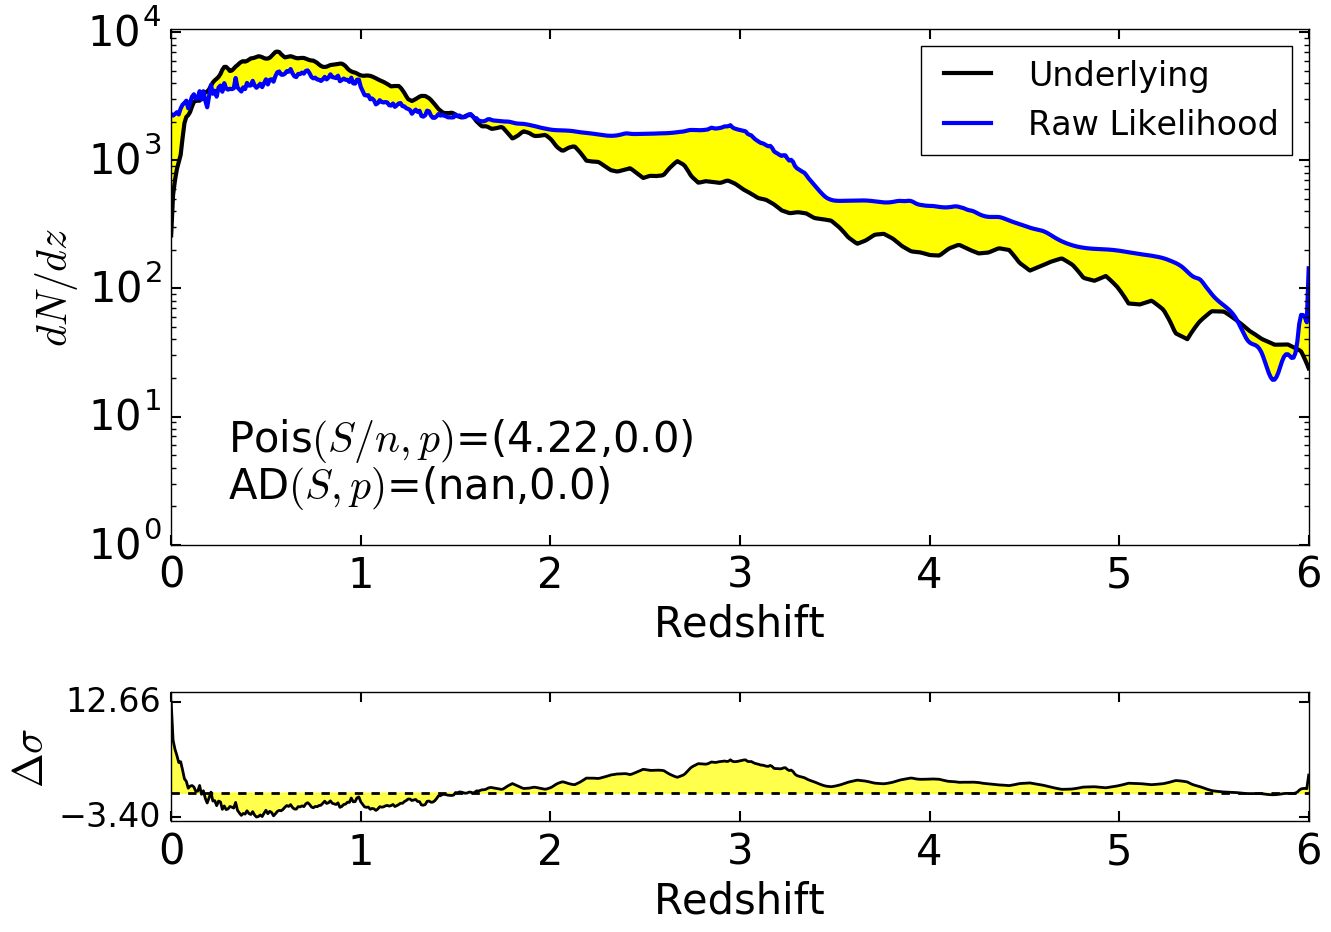

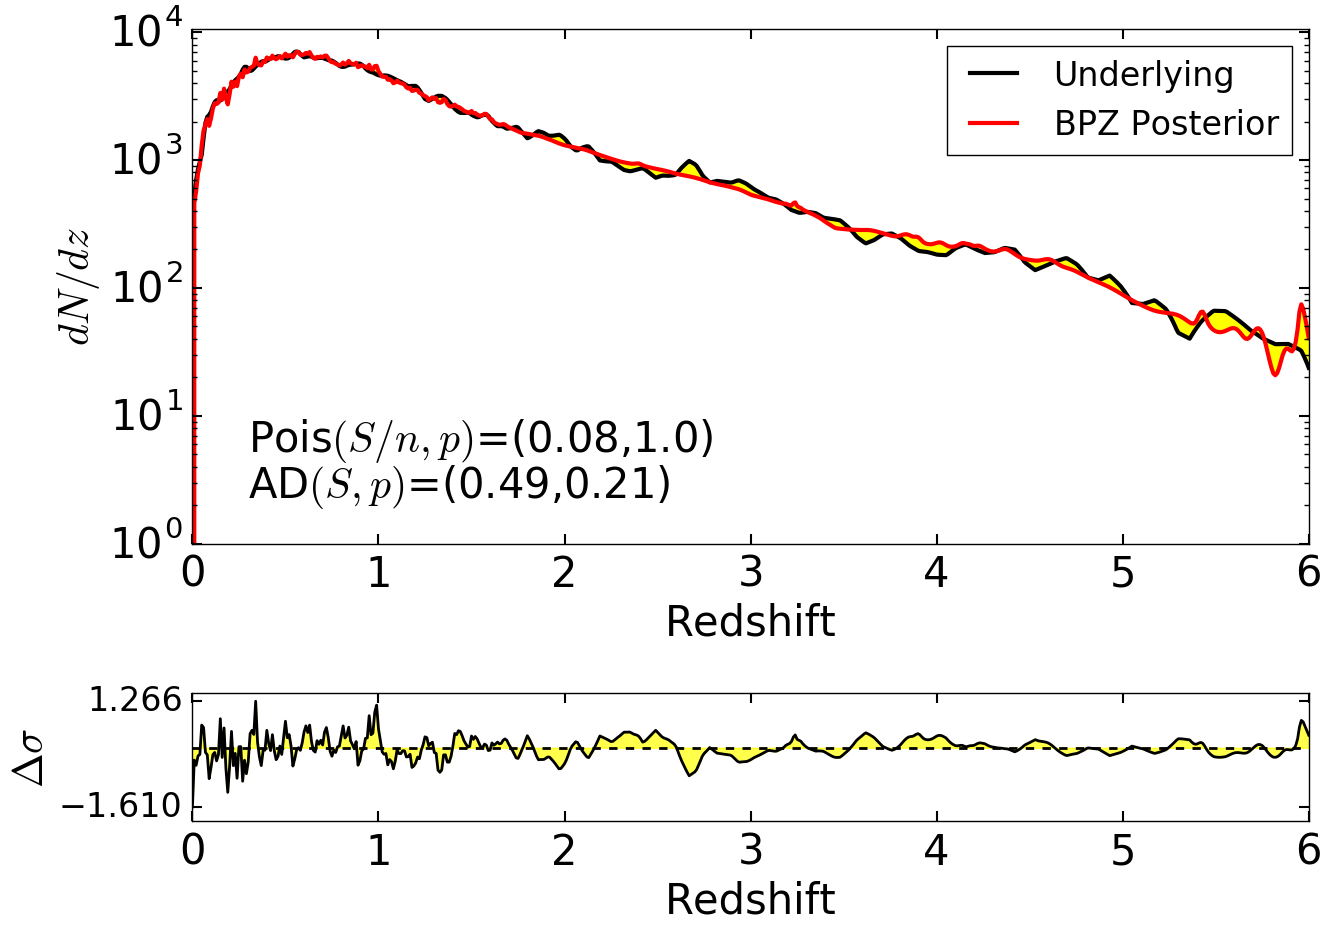

In [12]:
# Raw likelihoods
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,nansum(zpdf_raw,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Raw Likelihood'],colors=['black','blue'])

# BPZ posteriors
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,nansum(zpdf_bpz,axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','BPZ Posterior'],colors=['black','red'])

## Likelihood fitting with unbiased training data

Now we move on to the more **realistic case** where we **don't** actually know the underlying models and priors used to generate the data. We assume that that the training set is an **representative but biased** sample of the observed data, where we undersample the distribution as a function of magnitude.

In [13]:
# select training/testing samples
ftrain=0.4 # fraction of sample available for training
Ntrain=int(Nsel*ftrain) # number of training objects
Ntest=Nsel-Ntrain # number of testing objects

train_sel=zeros(Nsel).astype(bool)
train_sel[choice(Nsel,size=Ntrain,replace=False)]=True # training selection flag
test_sel=(train_sel==False) # testing selection flag

In [14]:
# applying magnitude bias
def pmag(mag,maglim):
    return 0.25*(maglim-mag)+0.2 # dp/dmag=0.25, p(maglim)=0.2
    
p_imag=pmag(mag_d[sel][:,2],maglims[2])
p_imag[p_imag>1.]=1.
train_sel*=(random.uniform(size=Nsel)<p_imag)
Ntrain=train_sel.sum()

In [15]:
# define training/testing data
phot_train_d,var_train_d,mask_train_d=phot_d[sel][train_sel],var_d[sel][train_sel],mask_d[sel][train_sel] 
redshift_train_d,lzidx_train_d,lzeidx_train_d=redshift_d[sel][train_sel],lzidx_d[sel][train_sel],lzeidx_d[sel][train_sel]

phot_test_d,var_test_d,mask_test_d=phot_d[sel][test_sel],var_d[sel][test_sel],mask_d[sel][test_sel]
redshift_test_d,lzidx_test_d,lzeidx_test_d=redshift_d[sel][test_sel],lzidx_d[sel][test_sel],lzeidx_d[sel][test_sel]

print 'Number of training objects:',Ntrain
print 'Number of testing objects:',Ntest

Number of training objects: 40477
Number of testing objects: 108698


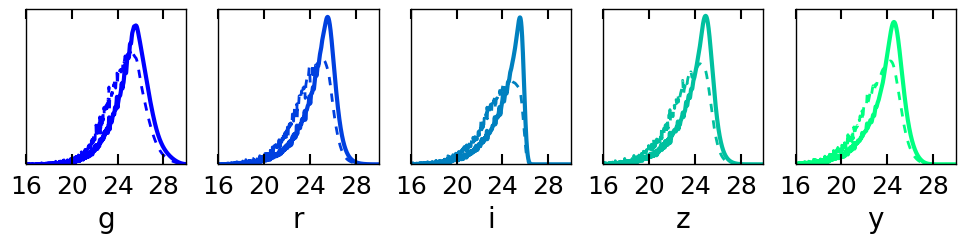

In [16]:
# plotting normalized magnitude PDFs
figure(figsize=(12,2))
for i in xrange(Nf):
    subplot(1,Nf,i+1)
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,midx_d[:,i][sel],meidx_d[:,i][sel],train_sel.astype(int),
                            mdict.grid,mdict.delta,mdict.Ngrid) # training
    plot(mdict.grid,mag_pdf/mag_pdf.sum(),lw=2,color=fcolors[i],linestyle='--')
    mag_pdf=fz.pdf_kde_dict(mdict.sig_dict,mdict.sig_width,midx_d[:,i][sel],meidx_d[:,i][sel],test_sel.astype(int),
                            mdict.grid,mdict.delta,mdict.Ngrid) # testing
    plot(mdict.grid,mag_pdf/mag_pdf.sum(),lw=3,color=fcolors[i])
    xlim([16,30])
    yticks([])
    xticks(arange(16,30,4),fontsize=18)
    xlabel(filt.filters[i],fontsize=20)

### Scale-free Likelihoods

The first thing we can do is treat these the exact same way we treated the original model grid and just fit them in color space using the scale-free likelihoods from before. 

In [17]:
downsample=10 # downsample the data since likelihood computation is relatively slow
Nsub=Ntest/downsample+1

In [18]:
# Redshift PDFs and -2ln(evidence) (raw)
lzpdf=empty((Nsub,rdict.Nz))
zpdf=empty((Nsub,Nz))
levidence=empty(Nsub)

sel_arr=arange(Ntest)[::downsample]
for count in arange(Nsub):
    if count%100==0: sys.stdout.write(str(count)+' ')
    i=sel_arr[count]
    ll,Nbands=fz.loglikelihood_s(phot_test_d[i],var_test_d[i],mask_test_d[i],
                                 phot_train_d,var_train_d,mask_train_d) # log-likelihoods and Nbands used in fit 
    llmin=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-llmin)) # transform to scaled likelihood weights
    levidence[count]=-2*log(weights.sum())+llmin # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d,lzeidx_train_d,weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[count]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# resample PDFs to output grid
zpdf=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 Resampling PDFs...0 5000 10000 done!


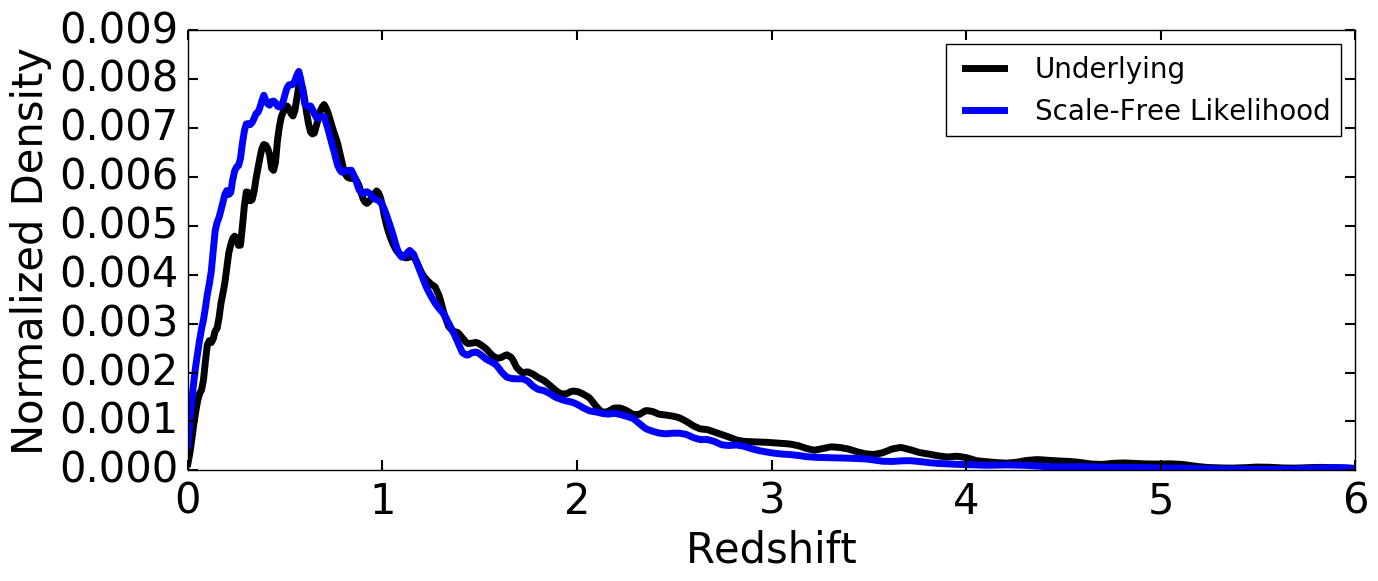

In [19]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d[::downsample],lzeidx_test_d[::downsample],
                      ones(Nsub),rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf,axis=0)/Nsub,lw=5,color='blue',label='Scale-Free Likelihood')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

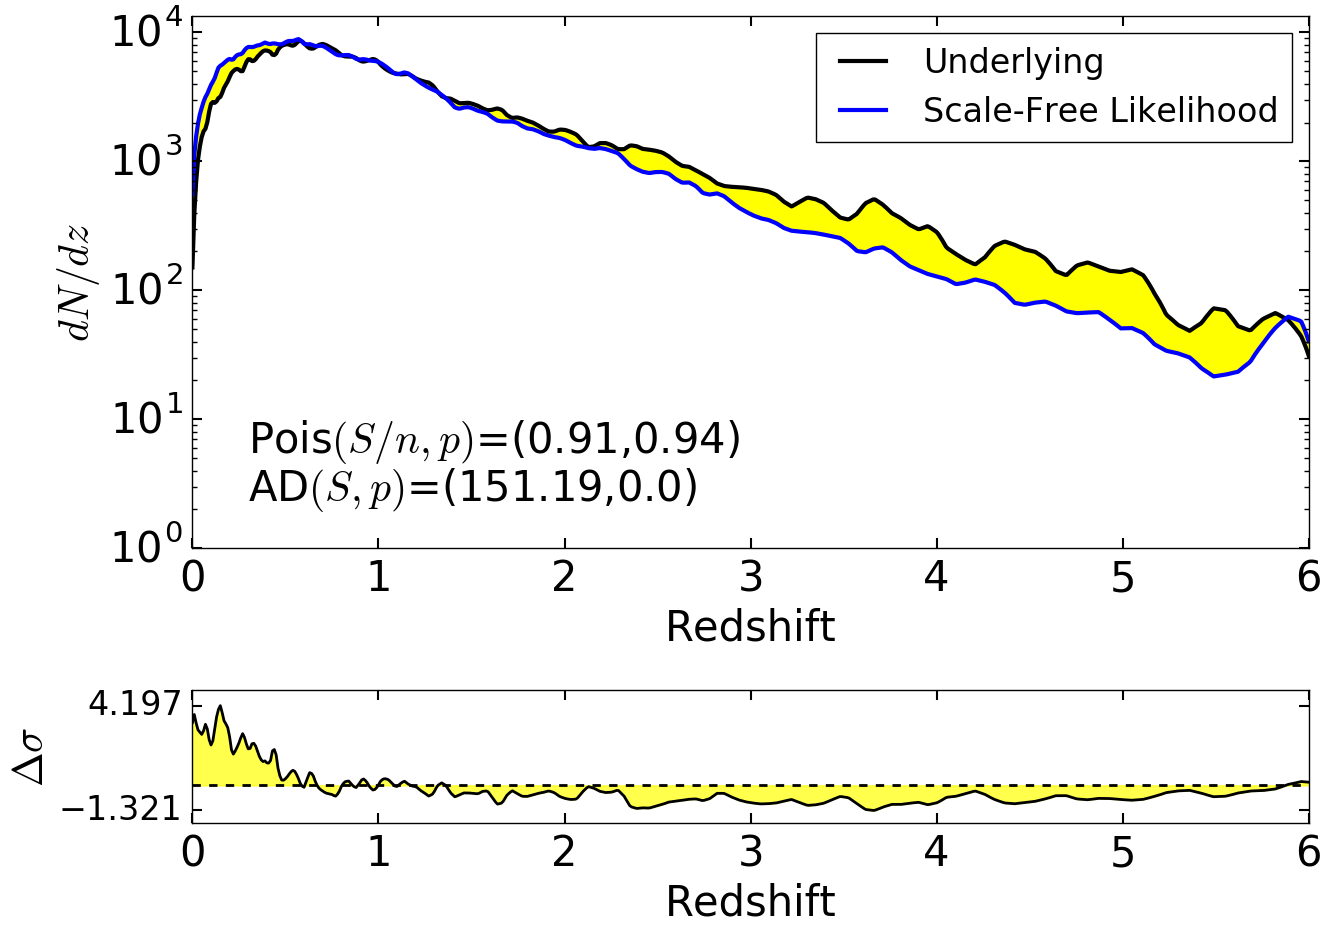

In [20]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,zpdf.sum(axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Scale-Free Likelihood'],colors=['black','blue'])

We notice that while the population distribution on the whole looks reasonable, it is **systematically offset** from the underlying distribution, with more likelihood concentrated at lower redshifts (at the expense of higher redshifts). This a consequence of better colors being available for brighter galaxies than fainter ones, which systematically upweights their contributions to the likelihood fit relative to the more plentiful fainter galaxies, especially since we ignore measurement errors in the training set photometry in order to render the scale-free likelihood computationally tractable (see above). The (differential) impact of this on the $N(z)$ distribution is shown below.

### Scale-dependent Likelihoods

We can attempt to solve this using an *extremely* simple approach: just switch from a scale-free to a **scale-dependent** likelihood (i.e. fitting in flux, not color)! The likelihood then simplifies to just becomes the products of two multivariate Gaussians with

\begin{equation}
-2\ln\mathcal{L} \propto \chi^2=\sum_i \frac{\left(F_{\textrm{obs},i} - F_{\textrm{model},i} \right)^2}{\sigma_{\textrm{obs},i}^2+\sigma_{\textrm{model},i}^2},
\end{equation}

giving us a way to analytically incorporate measurement error while *simultaneously* accounting for magnitude dependencies. It also is quicker to compute, which is always nice.

In [21]:
# Redshift PDFs and -2ln(evidence)
lzpdf=empty((Nsub,rdict.Nz))
zpdf2=empty((Nsub,Nz))
levidence2=empty(Nsub)

sel_arr=arange(Ntest)[::downsample]
for count in arange(Nsub):
    if count%100==0: sys.stdout.write(str(count)+' ')
    i=sel_arr[count]
    ll,Nbands=fz.loglikelihood(phot_test_d[i],var_test_d[i],mask_test_d[i],
                               phot_train_d,var_train_d,mask_train_d) # log-likelihoods and Nbands used in fit 
    llmin=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-llmin)) # transform to scaled likelihood weights
    levidence2[count]=-2*log(weights.sum())+llmin # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d,lzeidx_train_d,weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[count]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# resample PDFs 
zpdf2=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 Resampling PDFs...0 5000 10000 done!


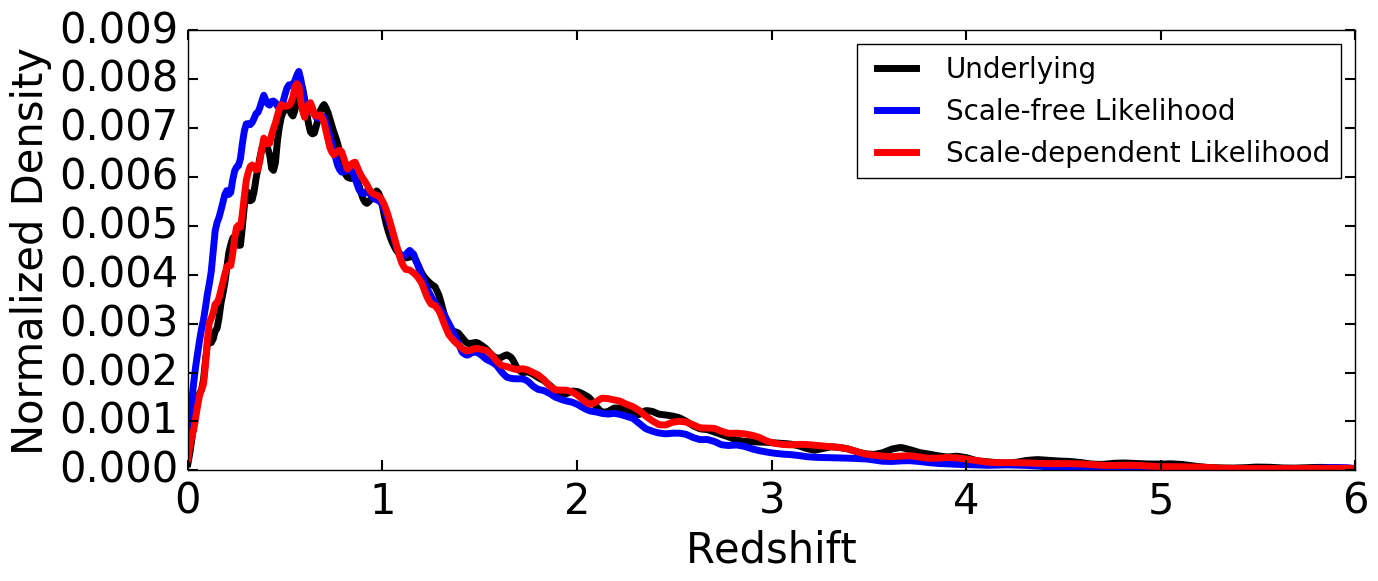

In [22]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d[::downsample],lzeidx_test_d[::downsample],
                      ones(Nsub),rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf,axis=0)/Nsub,lw=5,color='blue',label='Scale-free Likelihood')
plot(rdict.zgrid_out,nansum(zpdf2,axis=0)/Nsub,lw=5,color='red',label='Scale-dependent Likelihood')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

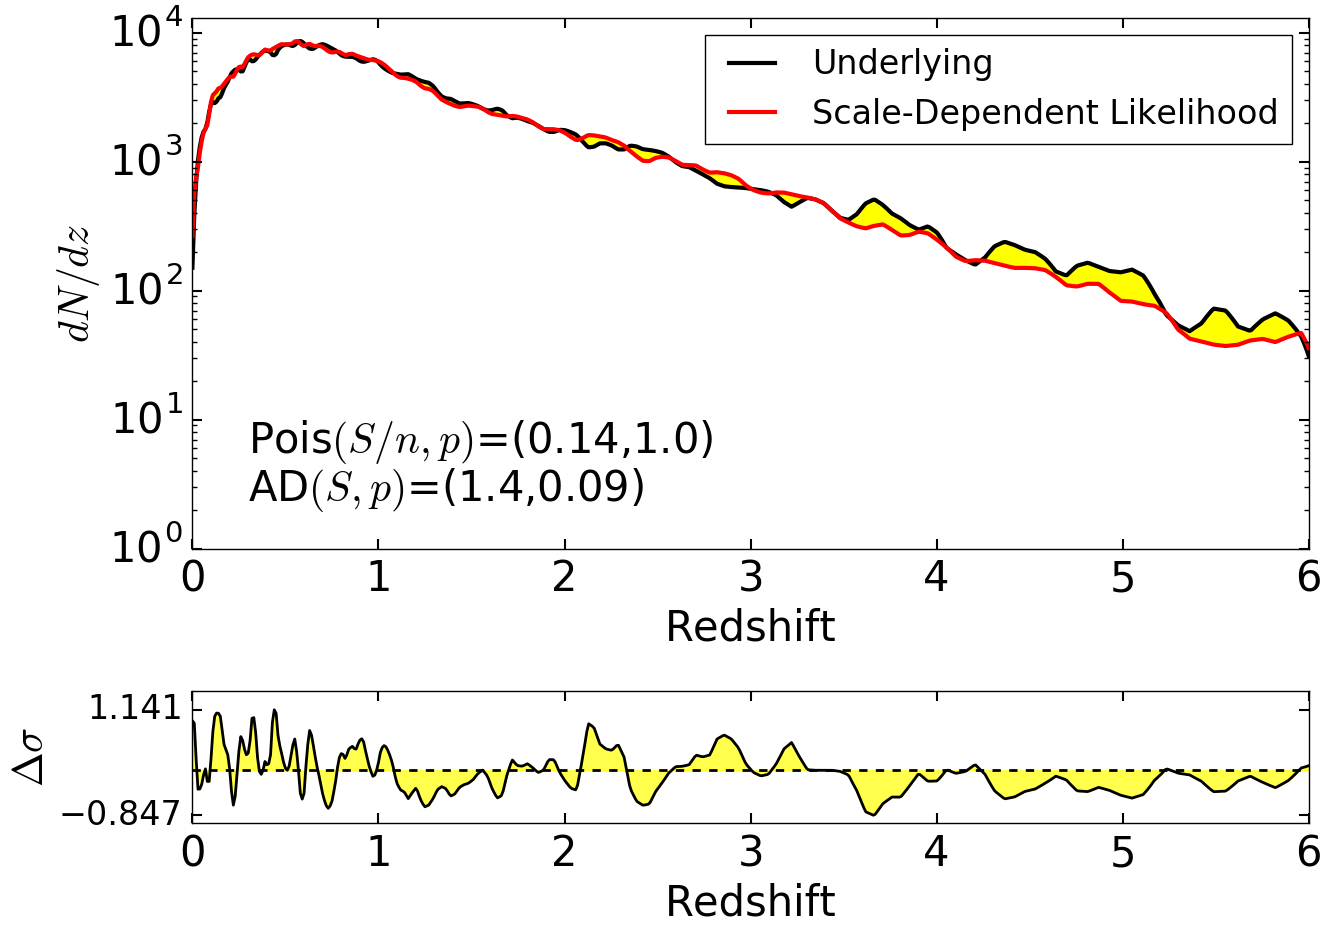

In [23]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Nsub,zpdf2.sum(axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','Scale-Dependent Likelihood'],colors=['black','red'])

This agrees with the true distribution much better than the previous scale-free case, which illustrates the power of intrinsically incorporating both magnitude information and (all) measurement errors into the likelihood function. When there is a representative enough subset of training data available over the magnitude ranges of interest, taking advantage of this approach is intuitive and mirrors findings from the machine learning community (discussed in more detail in Speagle et al. 2017).

## FRANKEN-Z

Now that we've shown that scale-dependent likelihoods are the way to go if you have representative training data, we turn to the computational challenge of exploiting that training data. In particular, taking a brute-force approach (as above) is prohibitively slow. It also penalizes you for expanding your training data, which we want to encourage rather than penalize!

To really solve this issue (which we foreshadowed in our discussion of KDE above), we turn to machine learning. Specifically, we want to develop a **sparse representation of the true likelihood distribution using a small, unbiased set of neighbors**. In other words, we want to select a small subset of objects ($N_{\textrm{neighbor}} \ll N_{\textrm{train}}$) and use the likelihood evaluated those as an approximation of the real thing.

We accomplish this by taking advantage of **k-d trees** to find neighbors in $\mathcal{O}(\log N)$ time (although this does strongly depend on dimensionality), which is a much softer penalty than the $\mathcal{O}(N)$ scaling imposed by brute-force approaches minus the (generally small) cost of originally constructing the tree. Using an ensemble of k-d trees trained/queried with Monte Carlo realizations of the input fluxes, we can guarantee an unbiased selection of (unique) neighbors gathered from across the ensemble that properly takes into account measurement errors on both datasets.

Once we have the sparse representation of the likelihoods in hand, we can then map them onto **any** target distribution using weighted KDE.

Our default *FRANKENZ* instance includes 100 trees and 10 neighbors (giving a total of $\leq\!1000$ unique neighbors). We'll just initialize things with 25 for now.

In [24]:
# initialize FRANKEN-Z instance
frankenz=fz.FRANKENZ(N_members=25)

FRANKEN-Z outputs a collection of associated model indices, the number of unique objects in each fit, the log-likelihood ($-2\ln\mathcal{L}$), and the numer of bands included in each fit. (We will discuss how FRANKEN-Z accounts for missing bands in the next module.)

In [25]:
# generate unique model predictions and corresponding log-likelihoods
model_obj,model_Nobj,model_ll,model_Nbands=frankenz.predict(phot_train_d,sqrt(var_train_d),mask_train_d,
                                                            phot_test_d,sqrt(var_test_d),mask_test_d)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


Note that we actually have generated predictions to the **entire** sample in the same amount of time than it took to generate predictions in the previous brute-force case after significant downsampling. We can now map our model distribution into redshift space.

In [26]:
# generate redshifts
model_llmin=empty(Ntest).astype(float)
lzpdf=empty((Ntest,rdict.Nz))
zpdf_fz=empty((Ntest,Nz))
levidence_fz=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx,ll=model_obj[i][:Nm],model_ll[i][:Nm]
    model_llmin[i]=ll.min() # minimum value (for scaling)
    weights=exp(-0.5*(ll-model_llmin[i])) # transform to scaled likelihood weights
    levidence_fz[i]=-2*log(weights.sum())+model_llmin[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz=fz.pdfs_resample(rdict.zgrid,lzpdf/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


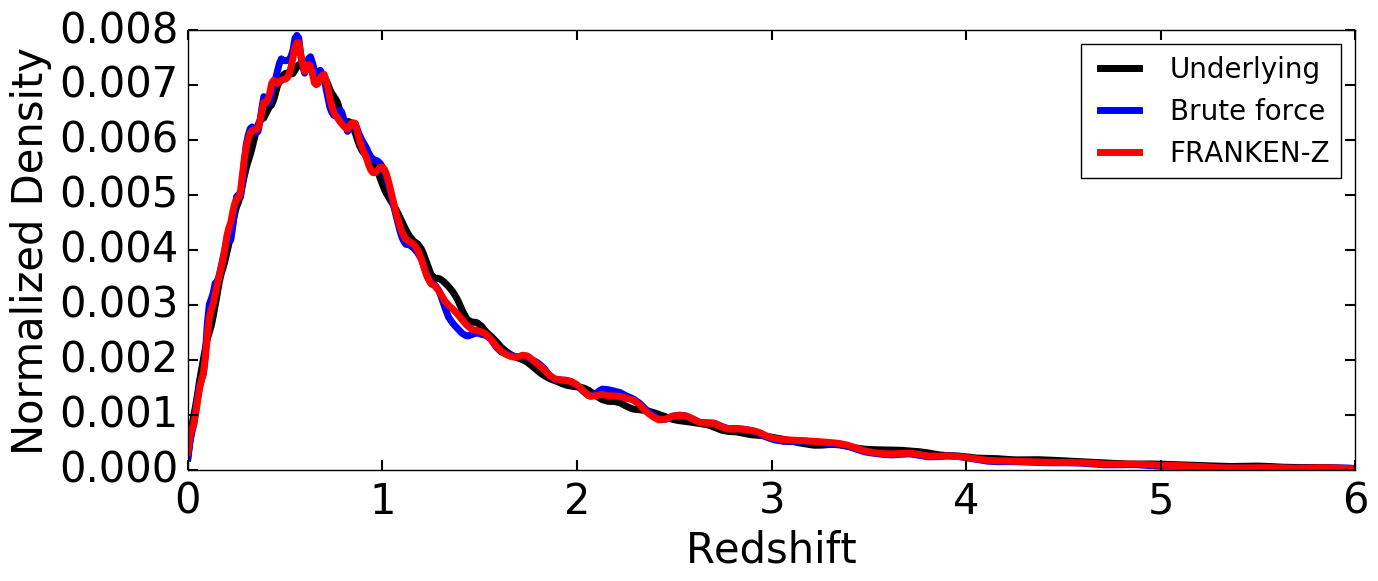

In [27]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# computed
plot(rdict.zgrid_out,nansum(zpdf2,axis=0)/Nsub,lw=5,color='blue',label='Brute force')
plot(rdict.zgrid_out,nansum(zpdf_fz,axis=0)/Ntest,lw=5,color='red',label='FRANKEN-Z')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

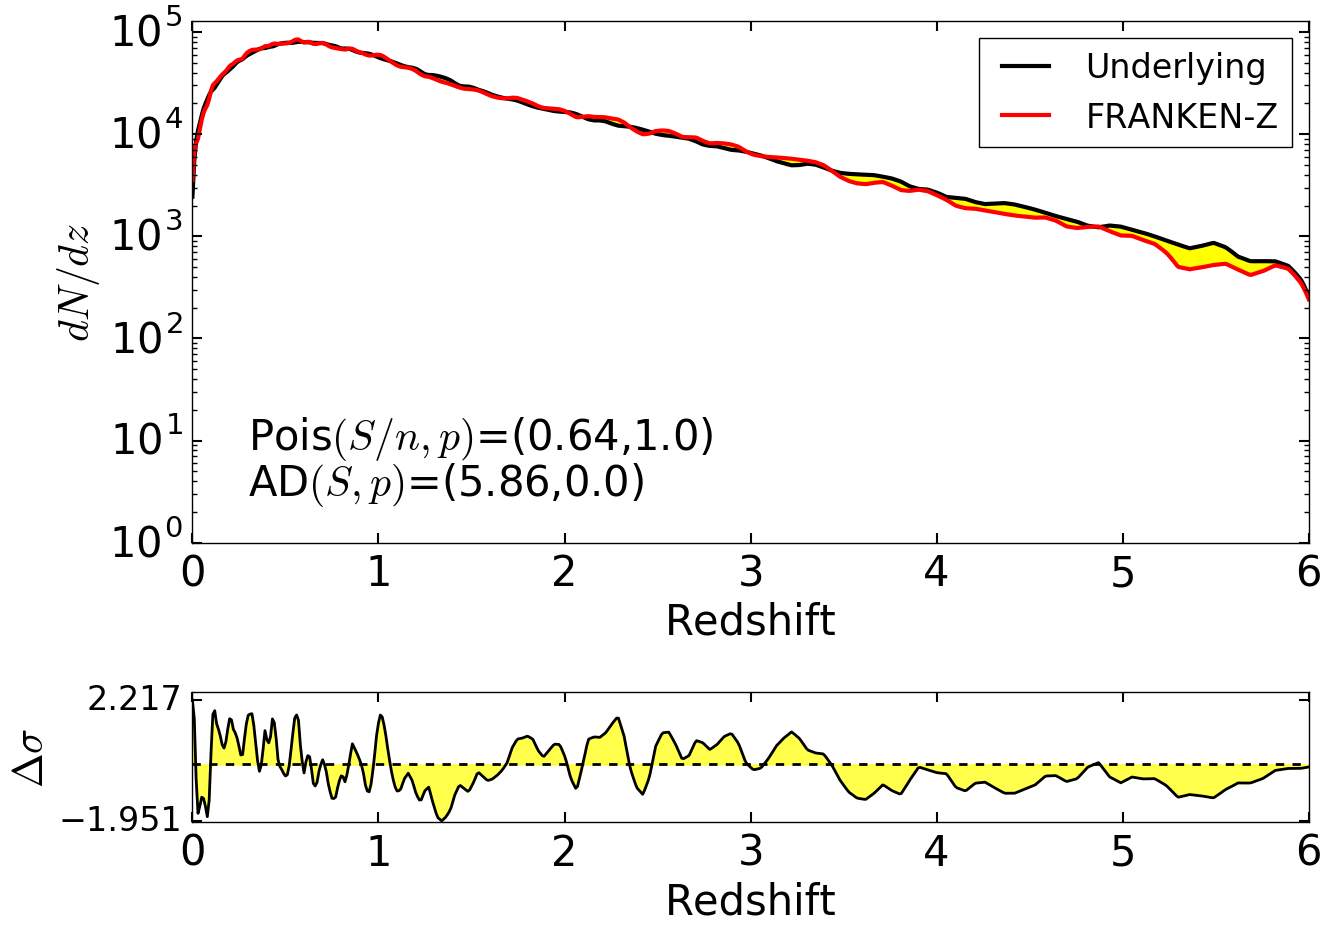

In [28]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Ntest,zpdf_fz.sum(axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','FRANKEN-Z'],colors=['black','red'])

The agreement between the two distributions is quite good overall, although we notice that many of the "bumps and wiggles" imprinted in the PDF remain even as we've "scaled up" to larger samples. This indicates they're artifacts caused by our selection effect, which removes training data preferentially where the majority of the test set is located!

## Incorporating Selection Effects on the Testing Set

We now want to add a little bit of complexity to our model by incorporating in the impact of **selection effects** on the **testing** sample $\mathbf{g}$ via a binary selection flag $\boldsymbol{\gamma}$ (1=object selected, 0=object missing).

Conditioning on $\boldsymbol{\gamma}$, our original likelihood $P(g|h)$ for a testing object $g$ given a training object $h$ now becomes:

\begin{equation}
P(g|h,\gamma)=\frac{P(g|h)P(\gamma|g,h)}{P(\gamma|h)}=\frac{P(g|h)P(\gamma|g)}{P(\gamma|h)}=\frac{P(g|h)P(\gamma|g)}{\int P(g|h)P(\gamma|g) dg},
\end{equation}

where the integral in the denominator is taken over all possible flux realizations of $g$.

Since we are working with Gaussians, any cut (either S/N or a constant vector) is equivalent to a multi-dimensional flux cut along some flux vector $\mathbf{F}_{\textrm{cut}}(g)$. Our selection function for a galaxy $g$ with some observed flux $\mathbf{\hat{F}}_g$ can then be written as

\begin{equation}
P(\gamma|\mathbf{\hat{F}}_g)=\prod_i H(\hat{F}_{g,i}-(F_{cut})_i)=H(\mathbf{\hat{F}_g}-\mathbf{F}_{cut}),
\end{equation}

where $H$ is the Heavyside function, which evaluates to 1 for all $\mathbf{\hat{F}}>\mathbf{F}_{cut}$ elementwise and 0 otherwise. This gives

\begin{equation}
P(\gamma|g) = \int^{+\infty}_{\mathbf{F}_{cut}} \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g) d\mathbf{F} = 1-\int^{\mathbf{F}_{cut}}_{-\infty} \mathcal{N}(\mathbf{F}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g) d\mathbf{F} = \Phi_c(\mathbf{F}_{cut}|\mathbf{\hat{F}}_g,\mathbf{\hat{C}}_g),
\end{equation}

where $\mathcal{N}$ is the Normal (Gaussian) PDF and $\Phi_c$ is the Normal **complementary cumulative distribution function (CDF)**. Assuming again that $\mathbf{\hat{C}}_g=\textrm{diag}(\dots,\hat{\sigma}^2_{g,i},\dots)$, this can be written as a product of 1-D normal CDFs,

\begin{equation}
-2\ln P(\gamma|g)=-2 \sum_i \ln \left[ 1-\frac{1}{2}\textrm{erfc}\left[ \left(\hat{F}_{g,i}-F_{cut,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right] \right],
\end{equation}

where $\textrm{erfc}$ is the **complementary error function**. 

In other words, given our observed fluxes and errors, we infer we have some probability $P(\gamma|g)$ of actually selecting our galaxy in our sample, which involves simply integrating over the flux PDF contained within our selection box. This probability ranges from 1 (far away from the boundary) to $2^{-N_f}$ (right at the boundary), and can be directly computed.

In our simplistic $i$-band selection case here, we have a constant selection function over the entire catalog.

In [29]:
# establish flux cut
flux_cut=zeros(Nf)-inf
flux_cut[2]=fz.inv_asinh_mag_map(array([maglims]),array([ones(Nf)*0.2]),skynoise,zeropoint=flux_zeropoint)[0][0][2]

Computing our selection probability is then very straightforward.

In [30]:
# selection probability
phot_test_d_lsel=-2*sum(log(1-0.5*special.erfc((phot_test_d-flux_cut)/(sqrt(2*var_test_d)))),axis=1)

As $P(\gamma|g)$ is constant for fixed $g$ and variable $h$, it doesn't affect the overall shape/distribution of our likelihood. $P(\gamma|h)$, however, is not, and can be seen as the convolution of our *original likelihood* with the selection function. In  the scale-dependent case, this can be written as

\begin{equation}
P(\gamma|h) = \int P(g|h)P(\gamma|g) dg \propto \prod_{i} \int \mathcal{N}(\hat{F}_{g,i}|\hat{F}_{h,i},\hat{\sigma}^2_{h,i}+\hat{\sigma}^2_{g,i}) \left[1-\frac{1}{2}\textrm{erfc}\left[ \left(\hat{F}_{g,i}-F_{cut,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right] \right] d\hat{F}_{g,i}
\end{equation}
\begin{equation}
= \prod_{i} \left[ 1 - \frac{1}{2} \int \textrm{erfc}\left[ \left(\hat{F}_{g,i}-F_{cut,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right] \mathcal{N}(\hat{F}_{g,i}|\hat{F}_{h,i},\hat{\sigma}^2_{h,i}+\hat{\sigma}^2_{g,i})  \,d\hat{F}_{g,i} \right].
\end{equation}

This cannot be evaluated analytically, but can be approximated numerically using a series of Monte Carlo fluxes drawn from the observed flux distribution $\lbrace\mathbf{\hat{F}}_g^1,\mathbf{\hat{F}}_g^2,\dots,\mathbf{\hat{F}}_g^n\rbrace \sim \mathcal{N}(\mathbf{\hat{F}}_g|\mathbf{\hat{F}}_{h},\mathbf{\hat{C}}_{h}+\mathbf{\hat{C}}_{g})$ via

\begin{equation}
-2 \ln P(\gamma|h) \approx -2 \sum_{i} \ln \left( 1 - \frac{1}{2N} \sum_{t=1}^{N} \textrm{erfc}\left[ \left(\hat{F}^t_{g,i}-F_{cut,i}\right) / \sqrt{2}\hat{\sigma}_{g,i} \right] \right).
\end{equation}

In other words, we are integrating over our likelihood **weighting by our selection function $P(\gamma|g)$**. This systematically *downweights* contributions near the selection boundary, since we would be less likely to include an object in our sample if its flux was truly located there. As this integrand is always $\leq\!1$, this **boosts** our original likelihood in an attempt to correct for this effect.

In [31]:
model_lsel=copy(model_ll) # selection-modified likelihood
Nmc=100

# compute corrections
for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    Nm=model_Nobj[i]
    midx=model_obj[i][:Nm]
    xmu=phot_train_d[midx]
    xvar=var_train_d[midx]+var_test_d[i]
    samples=normal(xmu,sqrt(xvar),size=(Nmc,Nm,Nf)) # Monte Carlo draws
    x=(samples-flux_cut)/sqrt(2*var_test_d[i]) 
    model_lsel[i][:Nm]=-2*sum(log(1-special.erfc(x).sum(axis=0)/(2*Nmc)),axis=1)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 

Let's now check our new redshifts.

In [32]:
# generate redshifts
model_llmin_sel=empty(Ntest).astype(float)
lzpdf_sel=empty((Ntest,rdict.Nz))
zpdf_fz_sel=empty((Ntest,Nz))
levidence_fz_sel=empty(Ntest)

for i in xrange(Ntest):
    if i%1000==0: sys.stdout.write(str(i)+' ')
    lpsel=phot_test_d_lsel[i]
    Nm=model_Nobj[i]
    midx,ll,lsel=model_obj[i][:Nm],model_ll[i][:Nm],model_lsel[i][:Nm]
    llsel=(ll+lpsel-lsel) # selection-effect corrected probability
    model_llmin_sel[i]=llsel.min() # minimum value (for scaling)
    weights=exp(-0.5*(llsel-model_llmin_sel[i])) # transform to scaled likelihood weights
    levidence_fz_sel[i]=-2*log(weights.sum())+model_llmin_sel[i] # -2ln(Evidence)
    
    pz=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_train_d[midx],lzeidx_train_d[midx],weights,
                       rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
    lzpdf_sel[i]=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]

# normalize PDFs   
zpdf_fz_sel=fz.pdfs_resample(rdict.zgrid,lzpdf_sel/rdict.znorm,rdict.zgrid_out)

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 Resampling PDFs...0 5000 10000 15000 20000 25000 30000 35000 40000 45000 50000 55000 60000 65000 70000 75000 80000 85000 90000 95000 100000 105000 done!


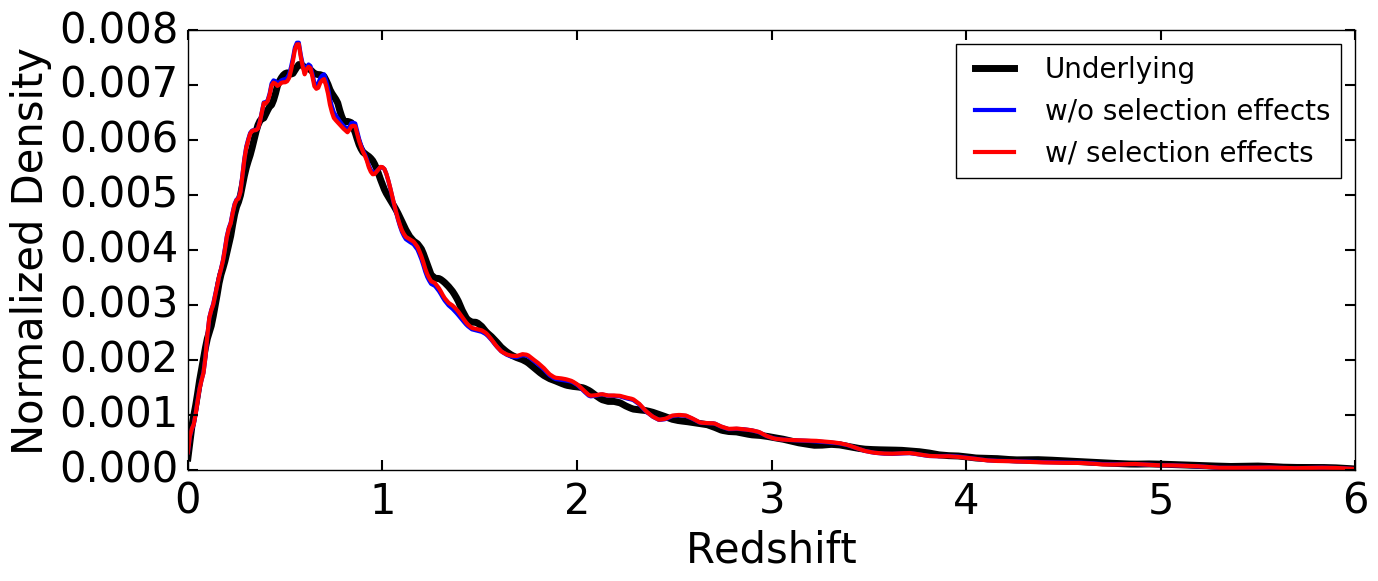

In [33]:
# plotting results
figure(figsize=(14,6))

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# original
pz=nansum(zpdf_fz,axis=0)/Ntest
plot(rdict.zgrid_out,pz,lw=3,color='blue',label='w/o selection effects')

# new
pz=nansum(zpdf_fz_sel,axis=0)/Ntest
plot(rdict.zgrid_out,pz,lw=3,color='red',label='w/ selection effects')
xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
legend(fontsize=20)
tight_layout()
xlabel('Redshift')
ylabel('Normalized Density')

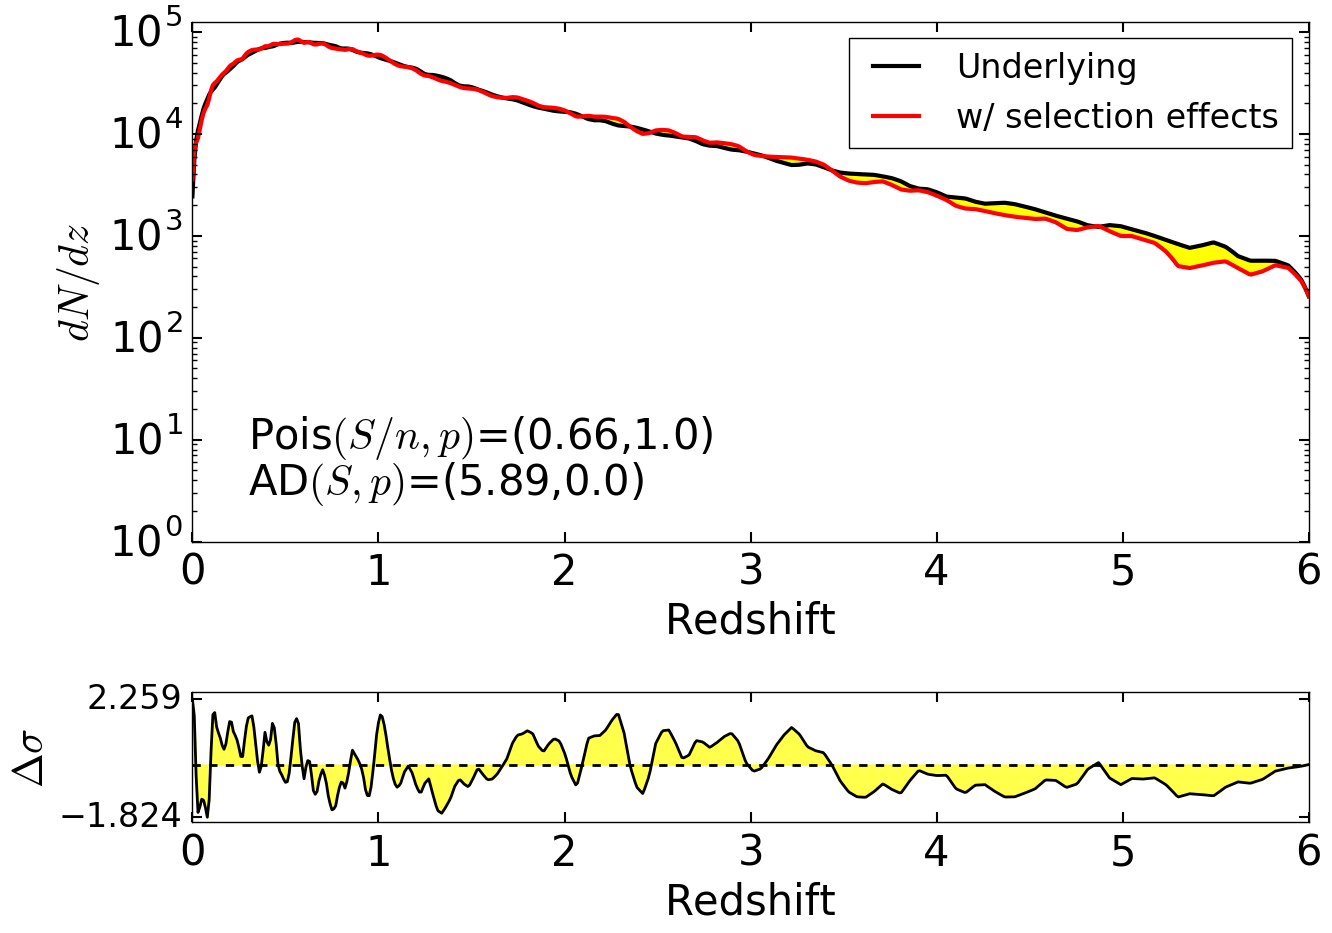

In [34]:
figure(figsize=(14,10))
Q_pois,Q_ad=fz.plot_nz(z_pdf*Ntest,zpdf_fz_sel.sum(axis=0),rdict.zgrid_out,rdict.dz_out,
                      sample_names=['Underlying','w/ selection effects'],colors=['black','red'])

The two are virtually indistinguishable, which makes sense: the use of our magnitude-dependent likelihood naturally ensures that nearby objects in magnitude space have the highest likelihoods, which by design have similar error properties in our mock data and thus similar selection probabilities and corrections.

**Important Note**: It is straightforward to broaden this framework to non-analytical forms of $P(\gamma|g)$. For instance, one might imagine that certain flux extraction issues might lead to selection biases as a function of magnitude on top of the Heavyside function. This might require exploiting more non-parametric machine learning algorithms to determine this relationship and additional work to marginalize over possible uncertainties in the results, but should be doable.

## Hierarchical Modeling

Now that we've demonstrated FRANKEN-Z works in the naive case and that we deal with missing data, we now want to incorporate hierarchical modeling. 

Why? Two main reasons:

- Hierarchical models allow the derivation of joint densities between the individual and population, which allows us to properly model **covariances**. This is crucial for understanding how the population can impact individual PDFs, and how the individual PDFs can impact the entire population (via their respective densities in flux space).
- In addition, hierarchical models allow us to start including selection effects **from the training data** into our model. These cannot be incorporated otherwise, since for a selection function over our training data $\eta(h)$, the conditional probability $P(g|h,\gamma,\eta)=P(g|h,\gamma)$ remains the same.

Our baseline model is

\begin{equation}
P(\mathbf{h},\mathbf{f^h}|\mathbf{g},\boldsymbol{\gamma}) \propto P(\mathbf{f^h}) P(\mathbf{h}|\mathbf{f^h},\boldsymbol{\gamma}) P(\mathbf{g}|\mathbf{h},\boldsymbol{\gamma}) = \prod_{g} P(\mathbf{f^h}|\gamma) P(h_g|\mathbf{f^h},\gamma) P(g|h_g,\gamma) = P(\mathbf{f^h}) \prod_{g} P(h_g|\mathbf{f^h}) P(g|h_g,\gamma),
\end{equation}

with $\mathbf{f^h}$ our population prior over $\mathbf{h}$ parameterized by a weight for each training object, and $h_g$ a neighboring training galaxy of $g$.

We can probe this distribution using a Gibbs sampler by alternating between sampling

\begin{equation}
P(\mathbf{f^h}|\mathbf{h},\mathbf{g},\boldsymbol{\gamma})=P(\mathbf{f^h}) P(\mathbf{f^h}|\mathbf{{Z}_h}),
\end{equation}

which is Dirichlet distributed as a function of the **Bayesian evidence** $\mathcal{Z}_h$ for each $h$ (see Speagle et al. in prep.), and 

\begin{equation}
P(\mathbf{h}|\mathbf{f^h},\mathbf{g},\boldsymbol{\gamma})= \prod_{g} P(h_g|\mathbf{f^h}) P(g|h_g,\gamma),
\end{equation}

which is just the original likelihood modified by the new conditional population prior.

To state things a bit more plainly, our hierarchical model has two parts: a population component and an individual component. To sample from the joint hierarchical distribution, all we have to do is sample from each of the conditional distributions: the population assuming we know the individual components, and then the individual components assuming we know the population. We continue this interative sampling until the distribution converges, at which point we are sampling from the true stationary distribution.

### Step 1. Set population prior $P(\mathbf{f^h})$

In [35]:
p_fh=ones(Ntrain)/Ntrain # uniform prior

### Step 2. Initialize conditional population prior $P(\mathbf{f^h}|\mathbf{Z_h})$

In [36]:
fh=zeros(Ntrain)

for i in xrange(Ntest):
    Nm=model_Nobj[i]
    lpsel=phot_test_d_lsel[i]
    midx,ll,lsel,llminsel=model_obj[i][:Nm],model_ll[i][:Nm],model_lsel[i][:Nm],model_llmin_sel[i]
    llsel=(ll+lpsel-lsel)
    weights=exp(-0.5*(llsel-llminsel))
    weights*=p_fh[midx] # multiply by global prior
    fh[midx]+=weights/weights.sum() # stack

### Step 3. Generate samples

Before we start sampling from the distribution, we want to point out just how powerful FRANKEN-Z's sparse representation of the likelihood actually is. Not only are we able to quickly iterate over the testing objects for computations (as above), but because we have actually stored all the "relevant" likelihoods **ahead of time** (which is impossible for brute-force approaches at this scale), we can re-use them in our later calculations without spending inordinate amounts of time recomputing the same quantities.

There's also an additional bonus: because of the structure of our hierarchical model, we can automatically infer an individual object's PDF at any given iteration of our sampler using our pre-computed likelihoods and $\mathbf{f^h}$. This means we don't have to store any of those interim values (which is memory intensive), but instead can generate them on demand as needed. This is useful, since while we're most often we're just interested in the population distribution, we don't actually lose any information by discarding the intermediate results.

In [37]:
N_samples=100
fh_t=zeros((N_samples,len(fh)))

# Gibbs sampler
fh_t[0]=fh # initialize

for i in xrange(N_samples-1):
    sys.stdout.write(str(i)+' ')
    fh_i=random.dirichlet(fh_t[i]+1) # draw population
    for j in xrange(Ntest):
        Nm=model_Nobj[j] # number of models
        lpsel=phot_test_d_lsel[j]
        midx,ll,lsel,llminsel=model_obj[j][:Nm],model_ll[j][:Nm],model_lsel[j][:Nm],model_llmin_sel[j]
        llsel=(ll+lpsel-lsel)
        weights=exp(-0.5*(llsel-llminsel))
        weights*=fh_i[midx]*p_fh[midx] # (P(pop_global)*P(pop_conditional)*likelihood)
        fh_t[i+1][midx]+=weights/weights.sum()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

As with standard Metropolis-Hastings Markov Chain Monte Carlo (MCMC) sampling, we first have to guarantee our sampler converges before we begin drawing values to derive a joint PDF. Using auto-correlations, we find that the chain usually has converged after 20 trials. Mapping our new high-dimensional $\mathbf{f^h}$ samples to redshift space using KDE is then pretty straightforward.

**Important sidenote**: To properly condition a covariance/precision matrix, we need as many samples as "free parameters". This means we're limited by the resolution of our grid, and that saving on computation time using fewer samples will require downsampling our redshift, mass, etc. grid to coarser resolution using, e.g., binning.

To properly convert from our $\mathbf{f^h}$ draws to corresponding $dN/dz$ draws, we need to sample from our Gibbs chain in two steps. First, we need to sample a series of training objects, and then for each of those training objects we need to sample from the underlying redshift kernel. This should naturally incorporate flux degeneracies, redshift uncertainties/kernel smoothing, and counting statistics into our $dN/dz$ draws.

In [38]:
N_burnin=20 # burn-in trials
z_pdf_draws=empty((N_samples-N_burnin,rdict.Nz_out)) # dn/dz draws

for i in xrange(N_burnin,N_samples):
    sys.stdout.write(str(i)+' ')
    midx=choice(Ntrain,p=fh_t[i]/fh_t[i].sum(),size=Ntest) # sample from f^h
    temp1,temp2=lzidx_train_d[midx],lzeidx_train_d[midx]
    pz=zeros(rdict.lzgrid_highres.shape)
    for j in xrange(Ntest):
        t1,t2=temp1[j],temp2[j]
        w,k=rdict.sig_width[t2],rdict.sig_dict[t2]
        pz[choice(xrange(t1-w,t1+w+1),p=k/k.sum())]+=1
    pz=pz[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
    pz=interp(rdict.zgrid_out,rdict.zgrid,pz)
    pz/=pz.sum()
    z_pdf_draws[i-N_burnin]=pz
z_pdf_draws_mean=z_pdf_draws.mean(axis=0)
z_pdf_draws_mean/=z_pdf_draws_mean.sum()

20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

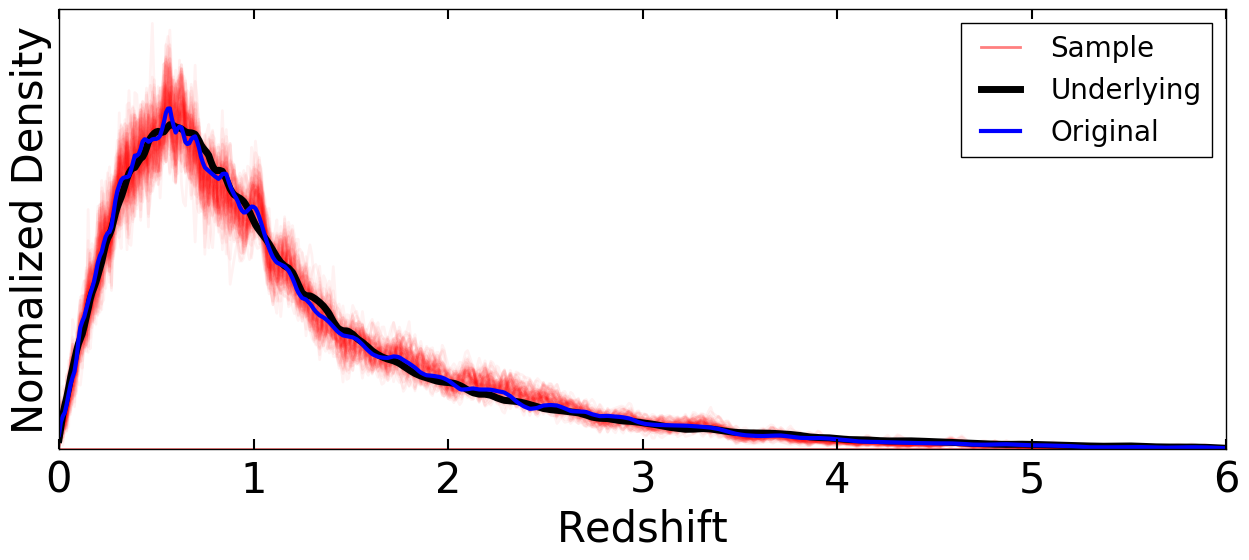

In [39]:
figure(figsize=(14,6))

#plot(rdict.zgrid_out,z_pdf_draws_mean,lw=5,color='black',alpha=0.5,label='Mean')
plot(rdict.zgrid_out,zeros(rdict.Nz_out),lw=2,color='red',alpha=0.5,label='Sample')
[plot(rdict.zgrid_out,z_pdf_draws[i],lw=2,color='red',alpha=0.05) for i in xrange(N_samples-N_burnin)]
#plot(rdict.zgrid_out,z_pdf_draws_mean,lw=5,color='black',alpha=0.5)

# observed
z_pdf=fz.pdf_kde_dict(rdict.sig_dict,rdict.sig_width,lzidx_test_d,lzeidx_test_d,ones(Ntest),
                      rdict.grid,rdict.delta,rdict.Ngrid) # KDE dictionary PDF
z_pdf=z_pdf[rdict.zmin_idx_highres:rdict.zmax_idx_highres:int(rdict.res)]/rdict.znorm
z_pdf=interp(rdict.zgrid_out,rdict.zgrid,z_pdf)
z_pdf/=z_pdf.sum()
plot(rdict.zgrid_out,z_pdf,lw=5,color='black',label='Underlying')

# original result
plot(rdict.zgrid_out,nansum(zpdf_fz_sel,axis=0)/Ntest,lw=3,color='blue',label='Original')

xlim([rdict.zgrid_out.min(),rdict.zgrid_out.max()])
tight_layout()
legend(fontsize=20)
xlabel('Redshift')
yticks([])
ylabel('Normalized Density')

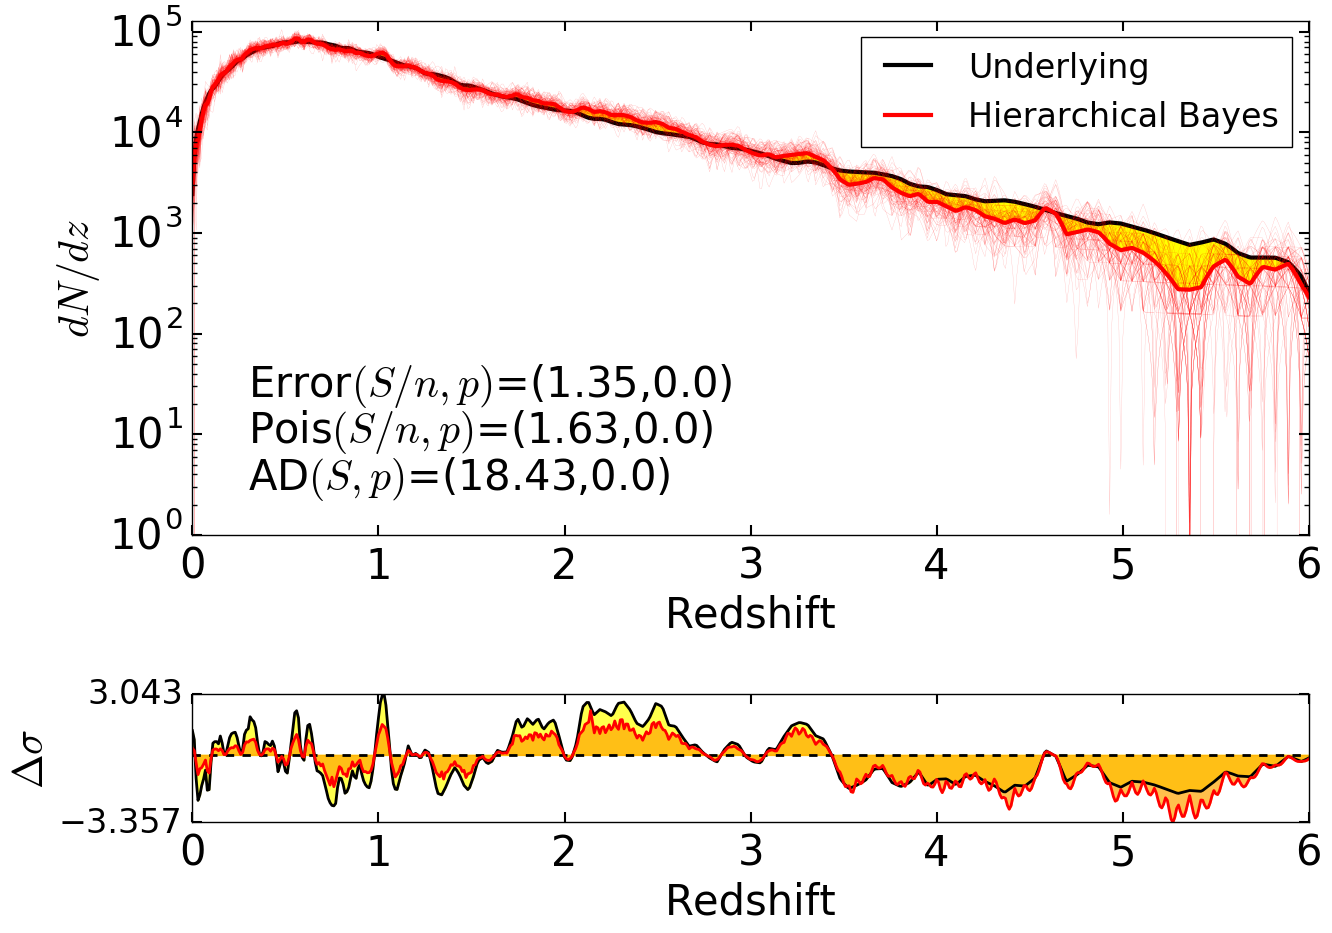

In [40]:
figure(figsize=(14,10))
Q_pois,Q_ad,Q_err=fz.plot_nz(z_pdf*Ntest,z_pdf_draws_mean*Ntest,rdict.zgrid_out,rdict.dz_out,out_nz_draws=z_pdf_draws*Ntest,
                             sample_names=['Underlying','Hierarchical Bayes'],colors=['black','red'])

As expected, our hierarchical modeling does a great job of modeling how covariances in flux space impact the $dN/dz$ distribution, properly accounting for how this uncertainty increases the errors over simple Poisson counting statistics.